## Welcome to the SVU Fall 2021 Hackathon

First we'll get a hold of the raw data

In [1]:
import pandas as pd

In [2]:
all_df = pd.read_csv('./data/owid-covid-data.csv')
print(all_df.shape)

(113405, 62)


There is some continent data mixed in with the country data. Let's filter that out so we only have countries represented.

In [3]:
countries_df = all_df[all_df.continent.notnull()]
print("countries_df",countries_df.shape)

countries_df (108187, 62)


Let's take a column at the columns we are dealing with...

In [4]:
for col in countries_df.columns:
    print(col)

iso_code
continent
location
date
total_cases
new_cases
new_cases_smoothed
total_deaths
new_deaths
new_deaths_smoothed
total_cases_per_million
new_cases_per_million
new_cases_smoothed_per_million
total_deaths_per_million
new_deaths_per_million
new_deaths_smoothed_per_million
reproduction_rate
icu_patients
icu_patients_per_million
hosp_patients
hosp_patients_per_million
weekly_icu_admissions
weekly_icu_admissions_per_million
weekly_hosp_admissions
weekly_hosp_admissions_per_million
new_tests
total_tests
total_tests_per_thousand
new_tests_per_thousand
new_tests_smoothed
new_tests_smoothed_per_thousand
positive_rate
tests_per_case
tests_units
total_vaccinations
people_vaccinated
people_fully_vaccinated
total_boosters
new_vaccinations
new_vaccinations_smoothed
total_vaccinations_per_hundred
people_vaccinated_per_hundred
people_fully_vaccinated_per_hundred
total_boosters_per_hundred
new_vaccinations_smoothed_per_million
stringency_index
population
population_density
median_age
aged_65_older


Let's now try a summary

In [5]:
death_sum_df = countries_df.groupby("location")["new_deaths"].sum().reset_index(name ='deaths')
print(death_sum_df)

              location   deaths
0          Afghanistan   7118.0
1              Albania   2498.0
2              Algeria   5269.0
3              Andorra    130.0
4               Angola   1217.0
..                 ...      ...
219            Vietnam  11064.0
220  Wallis and Futuna      0.0
221              Yemen   1472.0
222             Zambia   3602.0
223           Zimbabwe   4419.0

[224 rows x 2 columns]


Let's try some graphing now...

<AxesSubplot:>

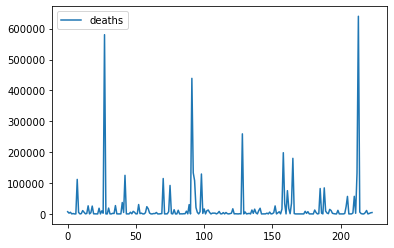

In [6]:
death_sum_df.plot()

Let's look at just countries with more than 150,000 total deaths.

          location    deaths
27          Brazil  580413.0
91           India  439020.0
128         Mexico  259326.0
158           Peru  198263.0
165         Russia  180009.0
213  United States  640108.0


<AxesSubplot:xlabel='location'>

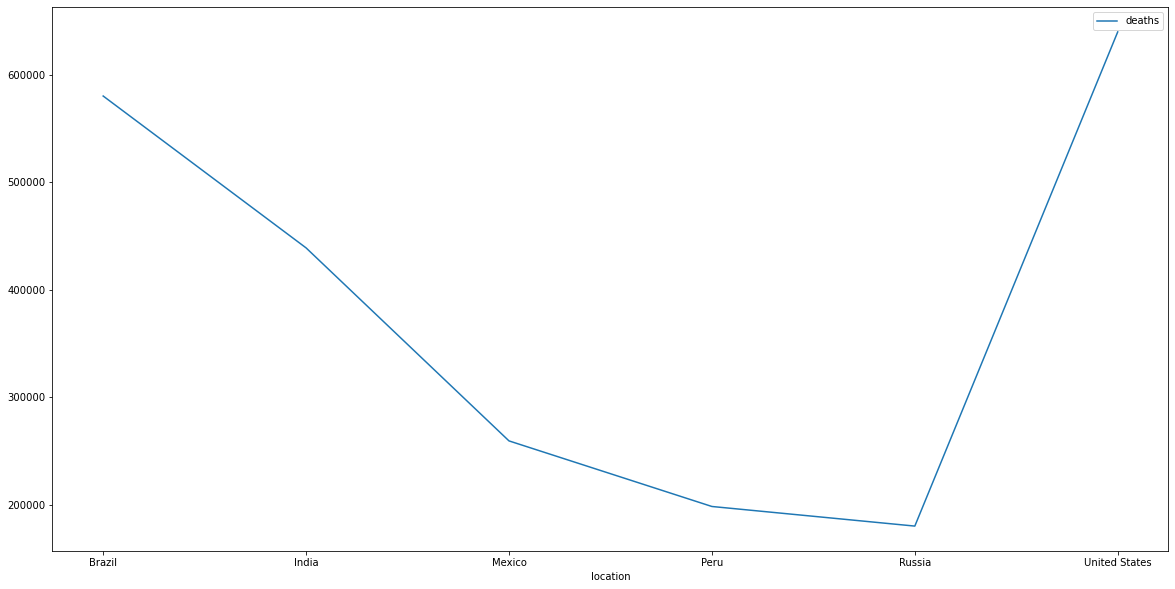

In [7]:
death_sum_high_df = death_sum_df[death_sum_df["deaths"] > 150_000]
print(death_sum_high_df)
death_sum_high_df.plot(x="location",y="deaths", figsize=(20,10))

Let's try a scatter plot showing "beds per thousand" vs "deaths"

In [8]:
death_hospital_beds_df = countries_df.groupby(["location","hospital_beds_per_thousand"])["new_deaths"].sum().reset_index(name ='deaths')
death_hospital_beds_df = death_hospital_beds_df[["hospital_beds_per_thousand","deaths"]]
print(death_hospital_beds_df)

     hospital_beds_per_thousand    deaths
0                          0.50    7118.0
1                          2.89    2498.0
2                          1.90    5269.0
3                          3.80      44.0
4                          5.00  111812.0
..                          ...       ...
166                        0.80    4010.0
167                        2.60   11064.0
168                        0.70    1472.0
169                        2.00    3602.0
170                        1.70    4419.0

[171 rows x 2 columns]


<AxesSubplot:xlabel='hospital_beds_per_thousand', ylabel='deaths'>

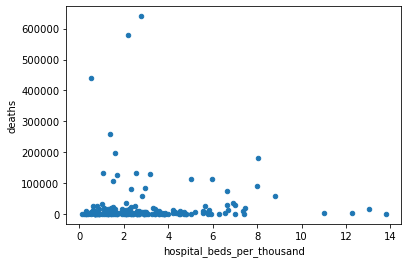

In [9]:
death_hospital_beds_df.plot.scatter(x="hospital_beds_per_thousand",y="deaths")

How about we trying some machine learning on this scatter data? 
It seems like a good candidate for a K-Means Clusterting algorithm. This will help find natural groups in our data. 

### Do the magic
Prep the dataset

In [10]:
import matplotlib.pyplot as plt
X = death_hospital_beds_df.iloc[:, [0,1]].values
print(X)

[[5.00000e-01 7.11800e+03]
 [2.89000e+00 2.49800e+03]
 [1.90000e+00 5.26900e+03]
 [3.80000e+00 4.40000e+01]
 [5.00000e+00 1.11812e+05]
 [4.20000e+00 4.84400e+03]
 [3.84000e+00 1.01200e+03]
 [7.37000e+00 1.07720e+04]
 [4.70000e+00 5.63600e+03]
 [2.90000e+00 3.54000e+02]
 [2.00000e+00 1.38800e+03]
 [8.00000e-01 2.61950e+04]
 [5.80000e+00 5.00000e+01]
 [1.10000e+01 3.78000e+03]
 [5.64000e+00 2.53800e+04]
 [1.30000e+00 3.62000e+02]
 [5.00000e-01 1.28000e+02]
 [1.70000e+00 3.00000e+00]
 [1.10000e+00 1.84520e+04]
 [3.50000e+00 9.80300e+03]
 [1.80000e+00 2.26100e+03]
 [2.20000e+00 5.80413e+05]
 [2.70000e+00 9.00000e+00]
 [7.45400e+00 1.88960e+04]
 [4.00000e-01 1.71000e+02]
 [8.00000e-01 3.80000e+01]
 [8.00000e-01 1.90300e+03]
 [1.30000e+00 1.35000e+03]
 [2.50000e+00 2.69890e+04]
 [2.10000e+00 3.13000e+02]
 [1.00000e+00 1.00000e+02]
 [2.11000e+00 3.69370e+04]
 [4.34000e+00 4.61900e+03]
 [1.71000e+00 1.24945e+05]
 [2.20000e+00 1.47000e+02]
 [1.13000e+00 5.50600e+03]
 [5.54000e+00 8.33400e+03]
 

Using the elbow method to find the optimal number of clusters

C:\Users\k_jac\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


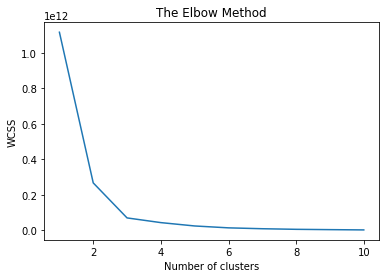

In [11]:
from sklearn.cluster import KMeans
wcss = []
for i in range(1,11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
plt.plot(range(1,11), wcss)
plt.title("The Elbow Method")
plt.xlabel("Number of clusters")
plt.ylabel("WCSS")
plt.show()

Looking at the above chart, where does the descent start slowing down?  I'd say around 3.

Let's now train the K-Means model on the dataset using a cluster number of 3

In [12]:
kmeans = KMeans(n_clusters = 3, init = 'k-means++', random_state = 42)
y_kmeans = kmeans.fit_predict(X)

Visualize the clusters

[[3.00316883e+00 6.51755844e+03]
 [1.83333333e+00 5.53180333e+05]
 [3.70642857e+00 1.30433214e+05]]


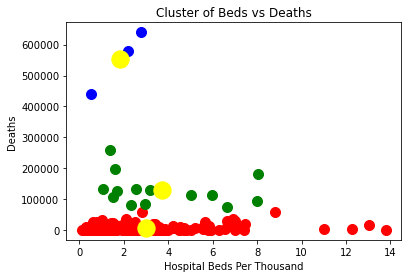

In [13]:
plt.scatter(X[y_kmeans == 0, 0], X[y_kmeans == 0, 1], s = 100, c = "red", label = "Cluster 1")
plt.scatter(X[y_kmeans == 1, 0], X[y_kmeans == 1, 1], s = 100, c = "blue", label = "Cluster 2")
plt.scatter(X[y_kmeans == 2, 0], X[y_kmeans == 2, 1], s = 100, c = "green", label = "Cluster 3")
print(kmeans.cluster_centers_)
plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], s=300, c="yellow", label = "Centroids")
plt.title("Cluster of Beds vs Deaths")
plt.xlabel("Hospital Beds Per Thousand")
plt.ylabel("Deaths")
plt.show()